In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\final_load_weather_data.csv")
df.head()


,ds,y,forecast_load,Unnamed: 0,dt,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,2015-01-01 01:00:00+00:00,26118.0,25385.0,11075,2015-01-01 02:00:00,2509954,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+00:00,26118.0,25385.0,63228,2015-01-01 02:00:00,3117735,266.186000,266.186000,266.186000,971,64,1,273,0.0,0.0,0.0,0,800
2,2015-01-01 01:00:00+00:00,26118.0,25385.0,116333,2015-01-01 02:00:00,3128026,269.251688,269.251688,269.251688,1036,97,1,224,0.0,0.0,0.0,0,800
3,2015-01-01 01:00:00+00:00,26118.0,25385.0,169280,2015-01-01 02:00:00,3128760,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0.0,0,800
4,2015-01-01 01:00:00+00:00,26118.0,25385.0,221705,2015-01-01 02:00:00,6361046,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0.0,0,800


ADF Statistic: -7.434754693335053
p-value: 6.225604400099643e-11


c:\Users\ASUS\OneDrive\Desktop\New folder\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



MAE: 2576.94, RMSE: 3090.35


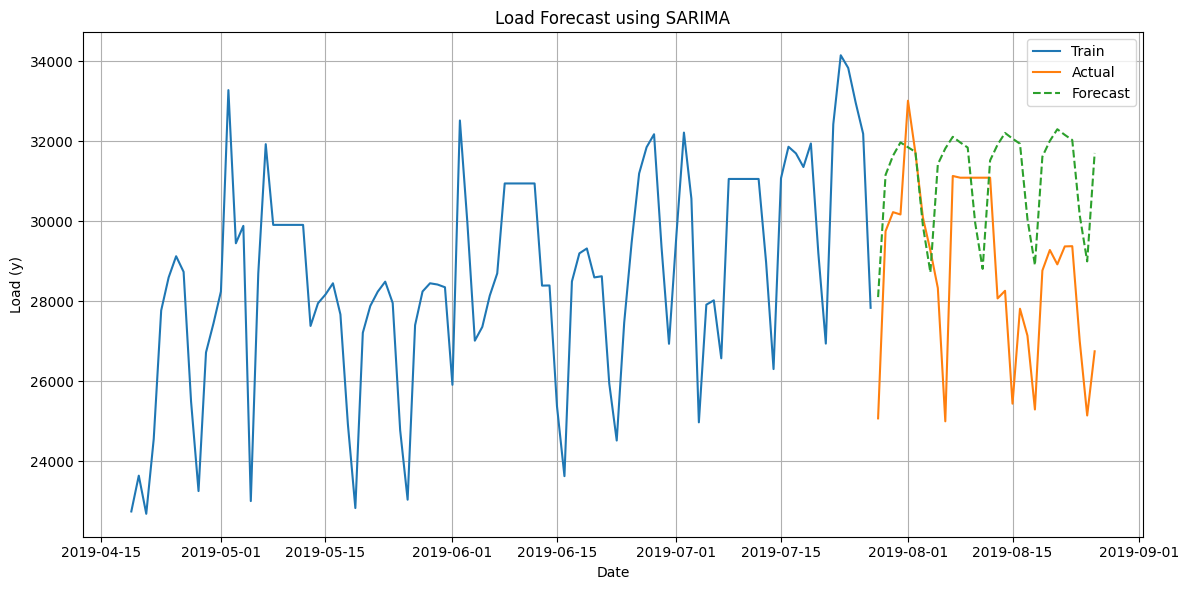

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# STEP 1: Prepare Data
df_arima = df.copy()
df_arima['ds'] = pd.to_datetime(df_arima['ds'])
df_arima.set_index('ds', inplace=True)

# Optional: Resample to daily average (for load optimization trends)
# You can also use 'H' for hourly forecasting
df_arima_daily = df_arima['y'].resample('D').mean().ffill()

# STEP 2: Stationarity Check (ADF Test)
result = adfuller(df_arima_daily)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# STEP 3: If p-value > 0.05, difference the series
if result[1] > 0.05:
    df_diff = df_arima_daily.diff().dropna()
else:
    df_diff = df_arima_daily

# STEP 4: Train-Test Split
train = df_arima_daily[:-30]  # all but last month
test = df_arima_daily[-30:]   # last month

# STEP 5: Fit SARIMA (Seasonal ARIMA) Model
# You can use auto_arima (pmdarima) to auto-tune (optional)
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,7))  # weekly seasonality
fit_model = model.fit(disp=False)

# STEP 6: Forecast
forecast = fit_model.forecast(steps=30)

# STEP 7: Evaluation
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")

# STEP 8: Visualization
plt.figure(figsize=(12,6))
plt.plot(train[-100:], label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title("Load Forecast using SARIMA")
plt.xlabel("Date")
plt.ylabel("Load (y)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\ASUS\OneDrive\Desktop\New folder\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


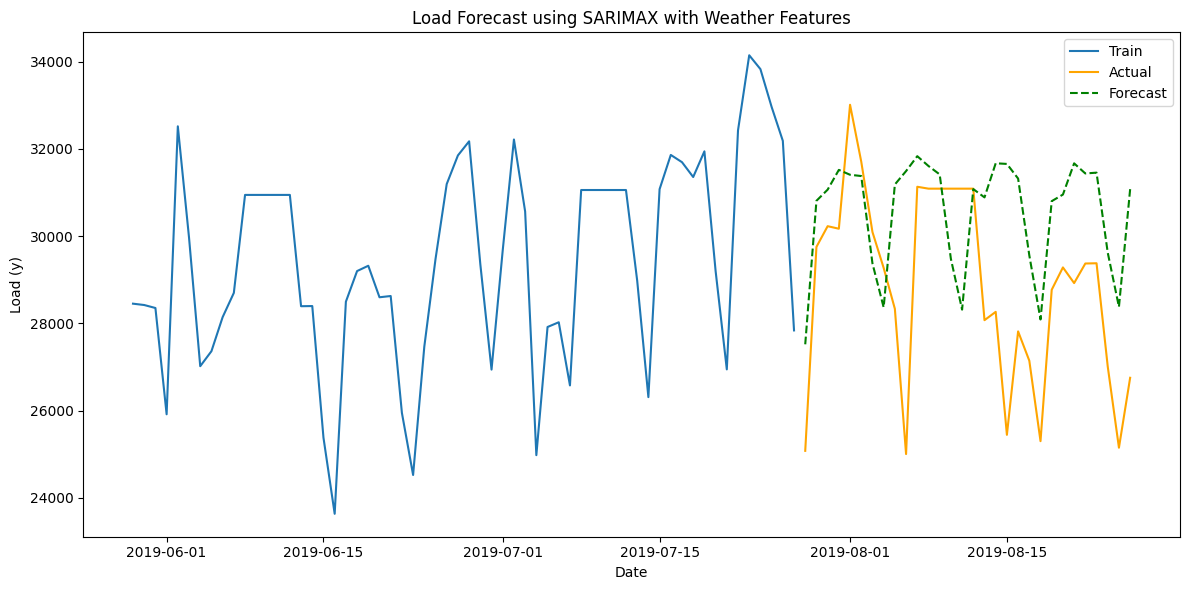

RMSE: 2695.30


In [5]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Make sure 'ds' is datetime and set it as index
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds')

# Step 2: Choose target variable and exogenous weather features
target = df['y']
exog_features = df[['temp', 'humidity', 'wind_speed']]

# Step 3: Optional resample to daily (if using hourly data, this smoothens)
target_daily = target.resample('D').mean().ffill()
exog_daily = exog_features.resample('D').mean().ffill()

# Step 4: Train-test split (e.g., last 30 days for test)
train_size = len(target_daily) - 30
y_train, y_test = target_daily[:train_size], target_daily[train_size:]
exog_train, exog_test = exog_daily[:train_size], exog_daily[train_size:]

# Step 5: Fit SARIMAX model with weather features
model = SARIMAX(y_train, exog=exog_train, order=(2,1,2), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False)

# Step 6: Forecast
forecast = model_fit.forecast(steps=30, exog=exog_test)

# Step 7: Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(y_train[-60:], label='Train')
plt.plot(y_test, label='Actual', color='orange')
plt.plot(forecast, label='Forecast', linestyle='dashed', color='green')
plt.title("Load Forecast using SARIMAX with Weather Features")
plt.ylabel("Load (y)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Evaluate
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f"RMSE: {rmse:.2f}")
